# Goal differences by month

One would think that teams tend to score more during the early season, when they are fresh and excited to play after offseason. 

Maybe teams don't also have so structured defence at the first months, and the goal totals decrease towards end of the season when team defence keeps improving during season.

Well, lets find out:

This analysis here pulls goal scoring data (only amount of goals) from regular season games, and stores them for each month and visualises the data.





In [143]:
import json
import requests
import pandas as pd
import calendar
import seaborn as sns
import matplotlib.pyplot as plt

BASE_URL = "https://statsapi.web.nhl.com"
SEASONS_LINK = "/api/v1/seasons"
SCHEDULE_LINK = "/api/v1/schedule"
GAMETYPE_REGULATION = "gameType=R"
SEASON = "season="
START_DATE = "startDate="
END_DATE = "endDate="
YEARS_QTY = 20

"""
season_data contains only the data needed for goals average analysis.

seasons is a list that contains more details about seasons/months that is useful
during processing
"""
season_data = []
seasons = []

months = [
          10,
          11,
          12,
          1,
          2,
          3,
          4
]

resp = requests.get("{}{}".format(BASE_URL,SEASONS_LINK))
seasons_all = json.loads(resp.text)

for i in range(YEARS_QTY+1, 1, -1):
  seasons.append({'seasonId': seasons_all['seasons'][-i]['seasonId']})


for season in seasons:
  for month in months:
    season[month] = {}
    season[month]['monthName'] = calendar.month_name[month]
    if month > 8:
      season[month]['monthEndDay'] = calendar.monthrange(int(season['seasonId'][:-4]), month)[1]
      season[month]['year'] = int(season['seasonId'][:-4])
    else:
      season[month]['monthEndDay'] = calendar.monthrange(int(season['seasonId'][-4:]), month)[1]
      season[month]['year'] = int(season['seasonId'][-4:])
    
    start_date = "{}-{}-01".format(season[month]['year'], str(month))
    end_date = "{}-{}-{}".format(season[month]['year'], str(month), season[month]['monthEndDay'])

    resp = requests.get("{}{}?{}&{}{}&{}{}".format(BASE_URL, SCHEDULE_LINK, GAMETYPE_REGULATION, START_DATE, start_date, END_DATE, end_date))
    games_month = json.loads(resp.text)
    season[month]['games'] = games_month['totalGames']

    #Calculate total goals
    month_goals = 0
    for date in games_month['dates']:
      for game in date['games']:
        month_goals = month_goals + game['teams']['away']['score'] + game['teams']['home']['score']
    #df.append(season['seasonId'], season[month]'[monthName'], month_goals)
    season[month]['totalGoals'] = month_goals
    
    try:
      season[month]['goalsAverage'] = month_goals / season[month]['games']
    except ZeroDivisionError:
      season[month]['goalsAverage'] = 0
    
    season_data.append([
                        season['seasonId'], 
                        season[month]['monthName'], 
                        season[month]['goalsAverage']
                        ])

#Uncomment if wanted to save to json file for viewing the data or external usage
"""
with open('data_seasons.json', 'w') as outfile:
		json.dump(seasons, outfile)
"""                

#Lets pass the data to Dataframe:
df = pd.DataFrame(season_data, columns = ['year', 'month', 'goalsAvg'])
print(df)

         year     month  goalsAvg
0    20002001   October  5.652695
1    20002001  November  5.356784
2    20002001  December  5.556650
3    20002001   January  5.478673
4    20002001  February  5.666667
..        ...       ...       ...
135  20202021  December  0.000000
136  20202021   January  6.029851
137  20202021  February  5.794444
138  20202021     March  5.752137
139  20202021     April  5.901345

[140 rows x 3 columns]


Now time for visualisation.

First, quick check if average goals per month give us any information:

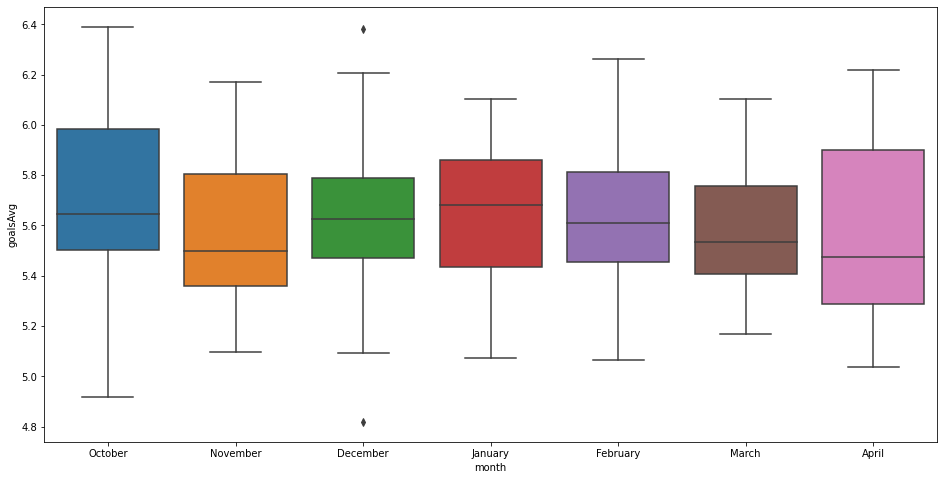

In [144]:

plt.figure(figsize=(16,8))
boxtwo = sns.boxplot(x = 'month',
                     y = 'goalsAvg',
                     data = (df[df['goalsAvg'] > 0]), #excule months with 0 goals (no season began yet)
                     order = [
                              "October",
                              "November",
                              "December",
                              "January",
                              "February",
                              "March",
                              "April"
                     ])

Well, that really dont give us much information. Maybe some conclusions can be made about October and and January having slightly higher goal totals. The graph above shows that monthly goal averages vary quite a lot (0.8-1.2 goals per month), which lead us to next thing:

Only way to have big sample size here is to increase amount of years. If we want to have sample size of 20 per month, we need to see results from 20 years. Following chart shows us how much goal averages vary between seasons:

        year  goalsAvg
0   20002001  5.490395
1   20012002  5.246174
2   20022003  5.319380
3   20032004  5.170633
4   20052006  6.170043
5   20062007  5.850316
6   20072008  5.534672
7   20082009  5.825053
8   20092010  5.694153
9   20102011  5.591569
10  20112012  5.485340
11  20122013  5.470426
12  20132014  5.416399
13  20142015  5.458335
14  20152016  5.460351
15  20162017  5.537666
16  20172018  5.967377
17  20182019  6.028698
18  20192020  6.001766
19  20202021  5.869444


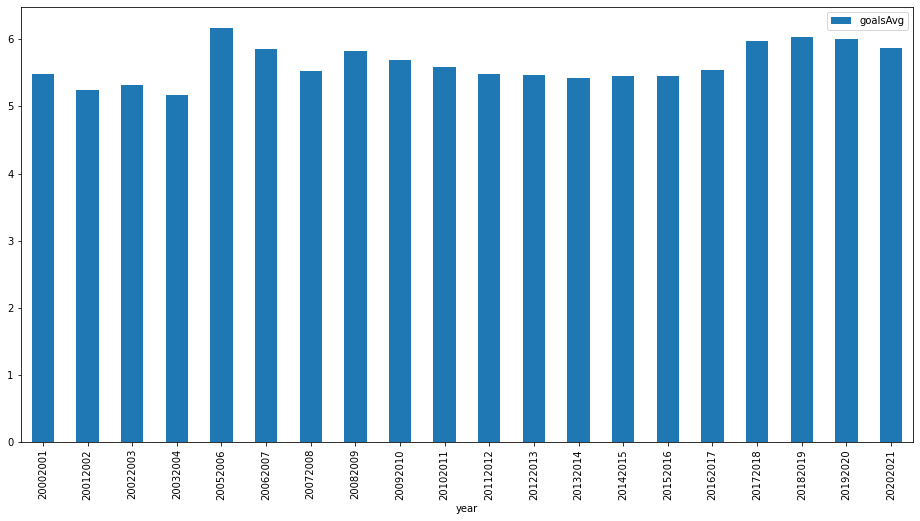

In [145]:
goals_avg_per_season = df[df['goalsAvg'] > 0].groupby('year').mean().reset_index()
goals_avg_per_season.plot(y='goalsAvg', x='year', kind = 'bar', figsize = [16,8])
print(goals_avg_per_season)
plt.show()

It shows that there is pretty big difference between seasons, and eras too. For example, the jump between seasons 2016-2017 and 2017-2018 is pretty high (maybe due to stricter line with slashing? Well that would be topic of its own).

So maybe it would be better to compare goal averages from each month to its season goal average.



In [146]:

df.loc[:,'seasonAvg'] = float(0.0)
df.loc[:,'seasonAvgDiff'] = float(0.0)

for index, row in df.iterrows():
  df.at[index, 'seasonAvg'] = goals_avg_per_season.loc[goals_avg_per_season['year'] == row['year'], ['goalsAvg']].values[0][0]
    
  
for index, row in df.iterrows():
  df.at[index, 'seasonAvgDiff'] = (row['goalsAvg'] / row['seasonAvg'] - 1) * 100

print(df)



         year     month  goalsAvg  seasonAvg  seasonAvgDiff
0    20002001   October  5.652695   5.490395       2.956065
1    20002001  November  5.356784   5.490395      -2.433542
2    20002001  December  5.556650   5.490395       1.206749
3    20002001   January  5.478673   5.490395      -0.213500
4    20002001  February  5.666667   5.490395       3.210547
..        ...       ...       ...        ...            ...
135  20202021  December  0.000000   5.869444    -100.000000
136  20202021   January  6.029851   5.869444       2.732907
137  20202021  February  5.794444   5.869444      -1.277802
138  20202021     March  5.752137   5.869444      -1.998614
139  20202021     April  5.901345   5.869444       0.543509

[140 rows x 5 columns]


Now we have a column "seasonAvgDiff", that shows how much goal average in month differs from season average (in percent). 

So what does the visualisation present us now?


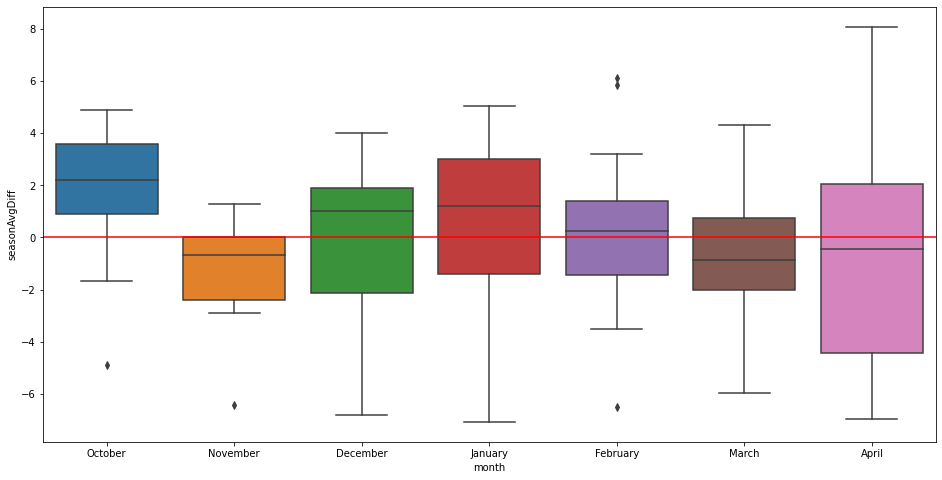

In [147]:
plt.figure(figsize=(16,8))
boxtwo = sns.boxplot(x = 'month',
                     y = 'seasonAvgDiff',
                     data = (df[df['goalsAvg'] > 0]), #excule months with 0 goals (no season began yet)
                     order = [
                              "October",
                              "November",
                              "December",
                              "January",
                              "February",
                              "March",
                              "April"
                     ])
plt.axhline(0, c='r')

Obviously while it is not certain that October is the highest scoring month of the season, the data seems to support that goal scoring is most likely above season average in October. Also November seems to have generally a bit lower goal scoring. Maybe structured team defence takes some time to get started, or perhaps after some period of time, coaches have enough material from opponents strategies to counter them?

Earlier boxplot that was comparing monthly averages in general showed something similar trend with early season, but this one seems to amplify those results.

However, there is not much conclusions that could be made for the rest of the season. Maybe January has something similar going on as October, after Christmas break, and also shortened seasons have started in January, so that probably has a minor effect on the results

